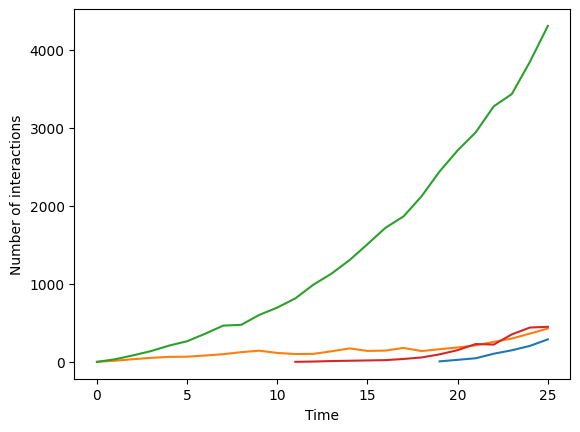

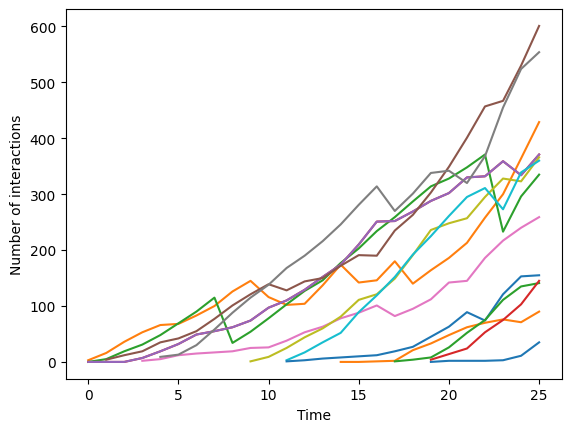

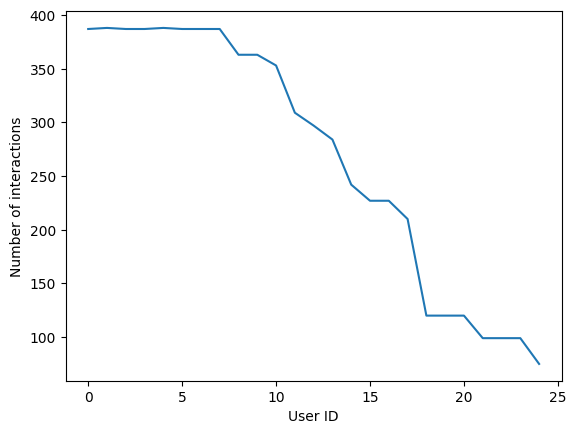

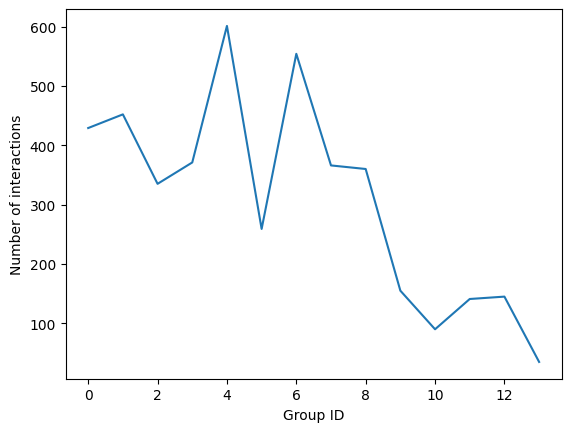

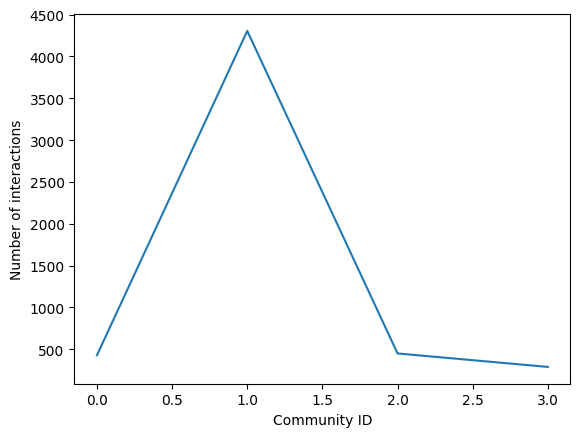

In [120]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt 
from math import floor

class Community:
    def __init__(self, group=None):
        # Initialize a community with a list of users and groups
        self.id = len(communities)
        self.groups = [group] if group else []
        self.interactions = []

class Group:
    def __init__(self):
        # Initialize a group with an ID and a dictionary tgo track user interactions
        self.id = len(groups)
        self.interactions = {}
        self.community : Community = None

    def join_community(self, community : Community):
        community.groups.append(self)
        self.community = community

class User:
    def __init__(self, group_alpha, group_beta, community_alpha, community_beta):
        # Initialize a user with ID, group memberships, interaction history, and Beta distribution preferences
        self.id = len(users)

        self.groups = []
        self.communities = []
        self.interaction_history = []

        self.group_preferences = stats.beta(group_alpha, group_beta)
        self.community_preferences = stats.beta(community_alpha, community_beta)


    def update_preferences(self):
        # Update user's preferences based on group interactions
        if not self.groups:
            self.updated_preferences = np.array([1])
            return
        else:
            #sort groups by number of interactions
            self.groups.sort(key=lambda group: len(group.interactions))

        total_size = sum([len(group.interactions) for group in self.groups])

        if total_size == 0:
            self.ccdf = np.array([1])
            return
        else:
            sizes = sorted([len(group.interactions) for group in self.groups])
            self.ccdf = 1 - (np.cumsum(sizes) / total_size)

        group_convolution = np.convolve(self.group_preferences.pdf(np.linspace(0, 1, len(self.groups))), self.ccdf , mode='same')

        self.updated_preferences = np.convolve(group_convolution, self.community_preferences.pdf(np.linspace(0, 1, len(self.groups))), mode='same')

        if np.isnan(self.updated_preferences).any() or np.sum(self.updated_preferences) == 0:
            self.updated_preferences = np.array([1 / len(self.groups)] * len(self.groups))
        else:
            self.updated_preferences /= np.sum(self.updated_preferences)

    def join_group(self, group):
        # Add a group to the user's group list and set initial interactions to 0
        self.groups.append(group)
        group.interactions[self] = 0

    def interact(self, group: Group):
        # Record an interaction with the specified group
        group.interactions[self] = group.interactions.get(self, 0) + 1
        self.interaction_history.append(group.id)


# Initialize lists to store users and groups
users = []
groups = []
communities = []

num_groups = len(groups)
num_communities = len(communities)


# Define simulation parameters
num_timesteps = 25

user_growth_rate = .1

group_join_rate = 0.00625
same_community_interaction_rate = 0.05

new_group_threshold = 0.05
new_community_threshold = 0.1
interaction_threshold = 1

alpha_group_hyperparameter = 10
beta_group_hyperparameter = 10 

alpha_community_hyperparameter = 10
beta_community_hyperparameter = 10

initial_users = 8
initial_groups = 4
initial_communities = 2


# Data structure for regression analysis
user_interactions = []
group_interactions = []
community_interactions = []


# Create initial users and groups
for _ in range(initial_users):
    user = User(np.random.uniform(1, alpha_group_hyperparameter),
                np.random.uniform(1, beta_group_hyperparameter),
                np.random.uniform(1, alpha_community_hyperparameter),
                np.random.uniform(1, beta_community_hyperparameter))
    users.append(user)

for _ in range(initial_communities):
    community = Community()
    communities.append(community)

    group = Group()
    groups.append(group)
    
    community.groups.append(group)

for _ in range(initial_groups - initial_communities):
  
    community = np.random.choice(communities)

    group = Group()
    group.id = len(groups) + 1
    group.join_community(community)
    groups.append(group)

# Initial user-group interactions
for user in users:
    for _ in range(floor(stats.expon.rvs(group_join_rate))):
        group = np.random.choice(groups)
        user.join_group(group)
    user.update_preferences()

for user in users:
    if user.groups:
        if np.random.rand() < interaction_threshold:
            group = np.random.choice(user.groups, p=user.updated_preferences)
            user.interact(group)        

# Record initial user interactions
for user in users:
    interactions_by_group = np.bincount([group.id for group in user.groups], minlength=num_groups)
    user_interactions.append([user.id, 0, *interactions_by_group])

gis = []        
for group in groups:
    gis.append(sum(list(group.interactions.values())))
group_interactions.append(gis)

cis = []
for community in communities:
    cis.append(sum([sum(list(group.interactions.values())) for group in community.groups]))
community_interactions.append(cis)

interactions = sum([len(group.interactions) for group in groups])

# Recalculate probabilities at every iteration or after any changes
def calculate_probabilities():
    global community_relative_frequency, group_relative_frequency

    community_relative_frequency = np.array([len(community.groups) for community in communities], dtype=float)
    if community_relative_frequency.sum() != 0:
        community_relative_frequency += 1e-5  # Avoid division by zero
        community_relative_frequency /= community_relative_frequency.sum()

    group_relative_frequency = np.array([sum(group.interactions.values()) for group in groups], dtype=float)
    if group_relative_frequency.sum() != 0:
        group_relative_frequency += 1e-5
        group_relative_frequency /= group_relative_frequency.sum()

# Initialize probabilities
# Main simulation loop
for time in range(num_timesteps):

    calculate_probabilities()


    for _ in range(floor(stats.expon.rvs(user_growth_rate))): 
        user = User(np.random.uniform(1, alpha_group_hyperparameter),
                    np.random.uniform(1, beta_group_hyperparameter),
                    np.random.uniform(1, alpha_community_hyperparameter),
                    np.random.uniform(1, beta_community_hyperparameter))
        users.append(user)

    for user in users:
        
        for _ in range(floor(stats.expon.rvs(group_join_rate))):

            calculate_probabilities()


            if np.random.rand() < new_group_threshold:
                group = Group()
                user.join_group(group)
                groups.append(group)


                if communities:  # Check if the list is not empty
                    if np.random.rand() < new_community_threshold:
                        community = Community(group)
                        communities.append(community)
                        group.join_community(community)
                    else:
                        community = np.random.choice(communities, p=community_relative_frequency)
                        group.join_community(community)

            else:
                if groups:  # Check if the list is not empty
                    group = np.random.choice(groups)
                    user.join_group(group)
                    
        if user.groups:
            user.update_preferences()
        else:
            user.updated_preferences = np.array([1])

        num_groups = len(groups)
        num_communities = len(communities)

        for user in users:
            if np.random.uniform() < interaction_threshold and user.groups:
                group = np.random.choice(user.groups, p=user.updated_preferences)

                if group.community:  # Check if the group is associated with a community
                    community = group.community

                    for _ in range(floor(same_community_interaction_rate * (len(community.groups) + 1))):
                        if np.random.uniform() < same_community_interaction_rate and community.groups:
                            group_comm = np.random.choice(community.groups)
                            user.interact(group_comm)

                    user.interact(group)
                    current_group = user.interaction_history[-1]
                else:
                    # join a community based on the probability distribution
                    community = np.random.choice(communities, p=community_relative_frequency)
                    group.join_community(community)
            else:
                user.interaction_history.append(1)
                current_group = user.interaction_history[-1]
            
        calculate_probabilities()


        if len(user.interaction_history) > 1:
            previous_group = user.interaction_history[-2]
            interactions_by_group = np.bincount(user.interaction_history, minlength=num_groups)
            user_interactions.append([user.id,current_group, *interactions_by_group])
        else:
            previous_group = current_group
            interactions_by_group = np.bincount(user.interaction_history, minlength=num_groups)
            user_interactions.append([user.id,current_group, *interactions_by_group])

    gis = []        
    for group in groups:
        gis.append(sum(list(group.interactions.values())))
    group_interactions.append(gis)

    cis = []
    for community in communities:
        cis.append(sum([sum(list(group.interactions.values())) for group in community.groups]))
    community_interactions.append(cis)

    calculate_probabilities()


community_interactions = pd.DataFrame(community_interactions)

for community in communities:
  c = community_interactions.iloc[:,community.id-1]
  plt.plot(c)

plt.xlabel('Time')
plt.ylabel('Number of interactions')
plt.show()

group_interactions = pd.DataFrame(group_interactions)

for group in groups:
  g = group_interactions.iloc[:,group.id-1]
  plt.plot(g)

plt.xlabel('Time')
plt.ylabel('Number of interactions')
plt.show()

uis = []
for user in users:
    uis.append(len(user.interaction_history))

plt.plot(uis)
plt.xlabel('User ID')
plt.ylabel('Number of interactions')
plt.show()


plt.plot(group_interactions.iloc[-1])
plt.xlabel('Group ID')
plt.ylabel('Number of interactions')
plt.show()

plt.plot(community_interactions.iloc[-1])
plt.xlabel('Community ID')
plt.ylabel('Number of interactions')
plt.show()


num_communities = len(communities)
num_groups = len(groups)

/Users/connorg0110/Library/Python/3.11/lib/python/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
/Users/connorg0110/Library/Python/3.11/lib/python/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, sigma_ar, ar, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 141 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


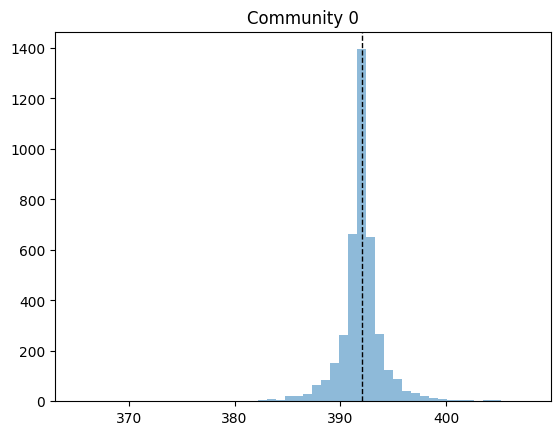

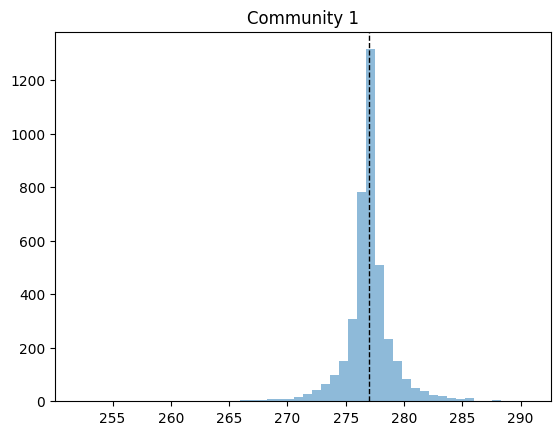

In [114]:
import pymc as pm
import arviz as az
import warnings
# regression model for num. of interactions of each group at each timestep

y = []
X = []
X1 = []

for community in communities:
    X.append(community_interactions.iloc[:,community.id-1]-community_interactions.iloc[:,community.id-1].shift(1))
    #plt.plot(group_interactions.iloc[:,group.id-1]-group_interactions.iloc[:,group.id-1].shift(1))
    
X = pd.DataFrame(X)
X.fillna(0, inplace=True)

y = X.iloc[:,-1]
y = pd.DataFrame(y)

y = y.to_numpy().flatten()


X = X.iloc[:,:-1]



model = pm.Model()

with model:
    try:
        # Data
        group_index = pm.Data('group_index', np.arange(num_communities), dims=('community'))
        X_data = pm.Data('X_data', X)
        y_data = pm.Data('y_data', y)

        # Priors
        rho = pm.Normal('phi', mu=0, sigma=10, shape=num_communities)
        sigma_ar = pm.Exponential('sigma_ar', lam=1)

        # AR Model
        ar = pm.AR('ar', rho=rho, sigma=sigma_ar, dims='community')

        # Likelihood
        sigma = pm.Exponential('sigma', lam=1)
        y_obs = pm.Normal('y_obs', mu=ar, sigma=sigma, observed=y_data, dims='community')

        # Sampling
        trace = pm.sample(1000, cores=4)
        posterior_predictive = pm.sample_posterior_predictive(trace)
    
    except pm.exceptions.SamplingError:
        warnings.warn('SamplingError: Skipping this group')


pred = posterior_predictive['posterior_predictive']['y_obs'].to_numpy()

shape = pred.shape
communities = shape[2]

# Initialize list of lists for each community
preds = [[] for _ in range(communities)]

for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(communities):
            preds[k].append(pred[i, j, k])

for k in range(communities):

    plt.hist(preds[k], bins=50, alpha=0.5, label='Community 1')
    plt.axvline(y[k], color='k', linestyle='dashed', linewidth=1)
    title = 'Community ' + str(k)
    plt.title(title)
    plt.xlabel("Number of interactions")
    plt.ylabel("Frequency")
    plt.show()


/Users/connorg0110/Library/Python/3.11/lib/python/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
/Users/connorg0110/Library/Python/3.11/lib/python/site-packages/pymc/distributions/timeseries.py:558: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, sigma_ar, ar, sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 25 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


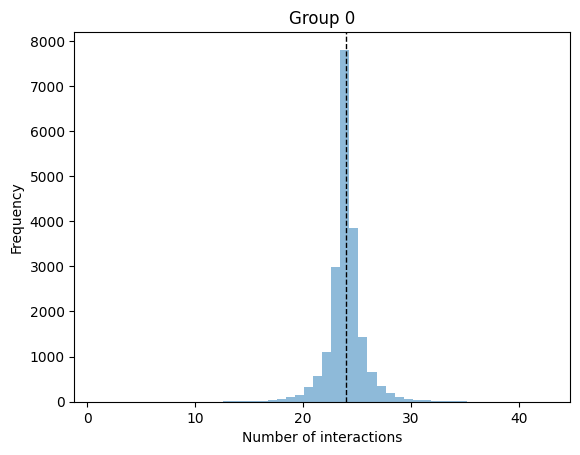

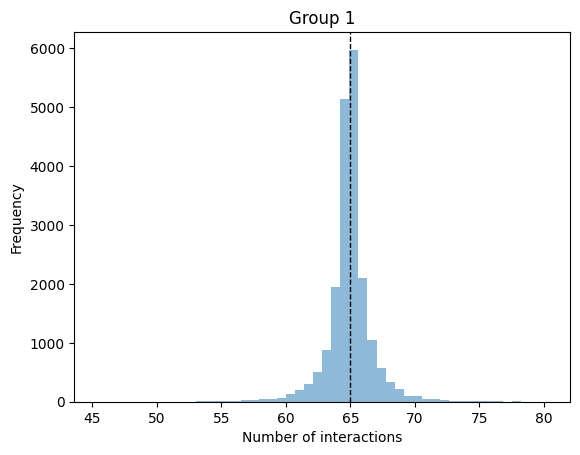

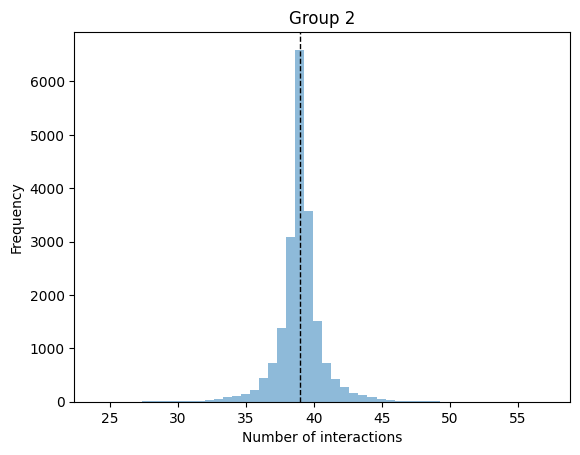

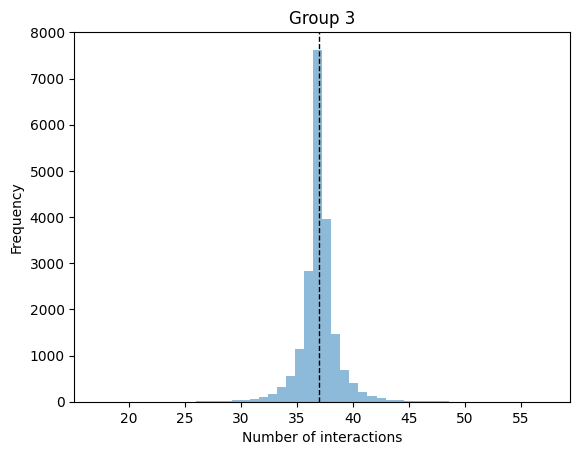

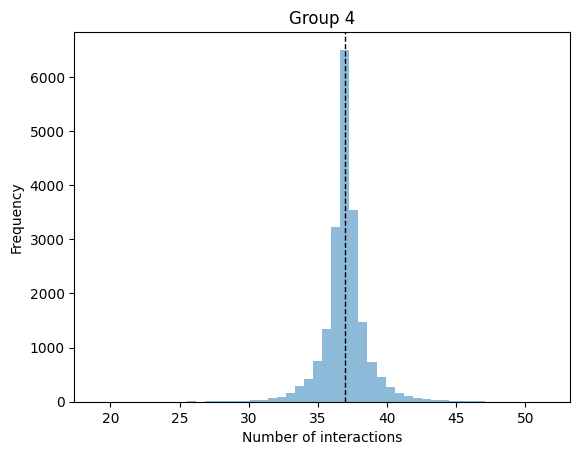

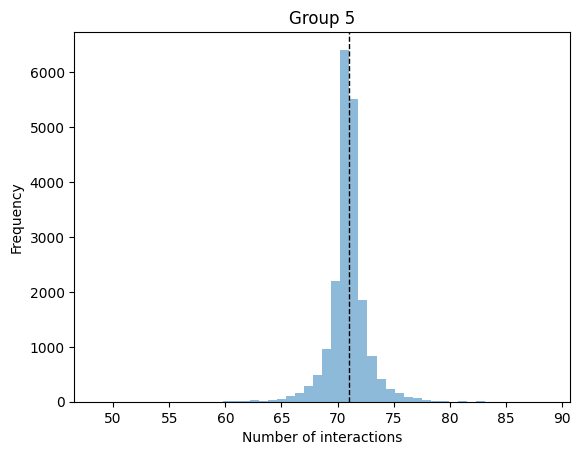

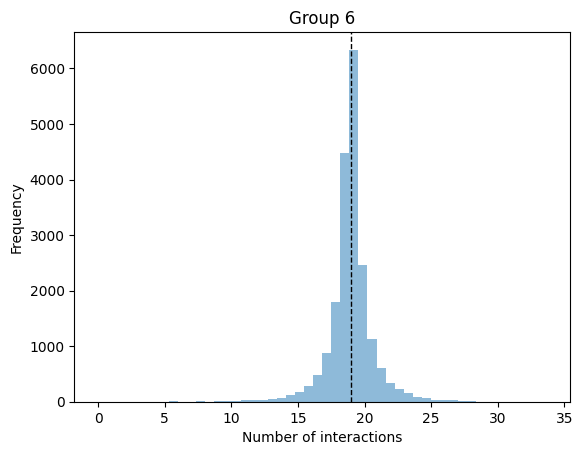

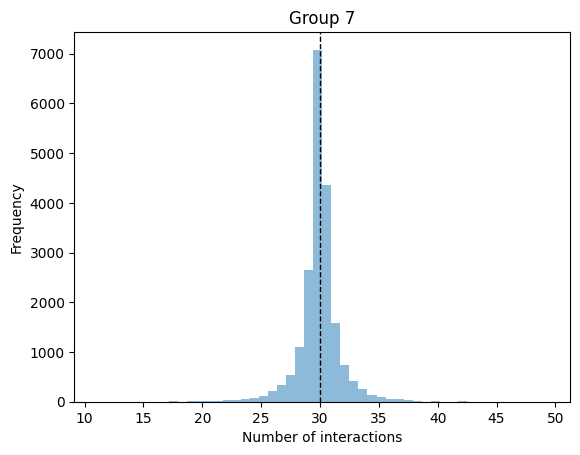

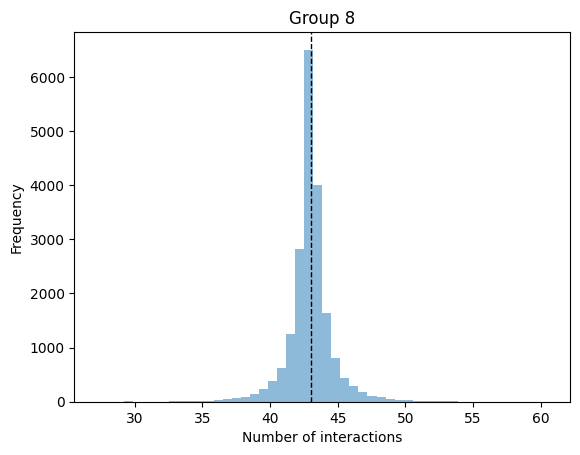

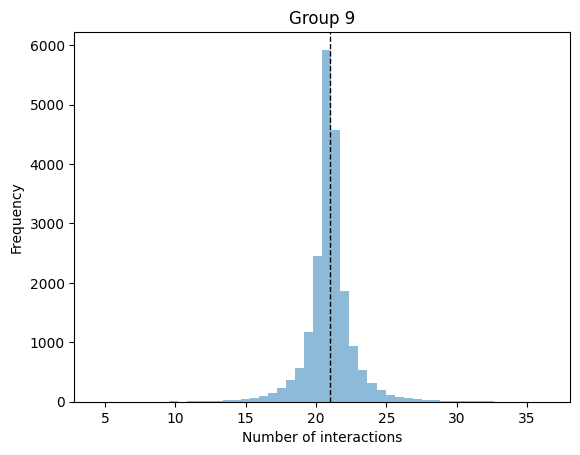

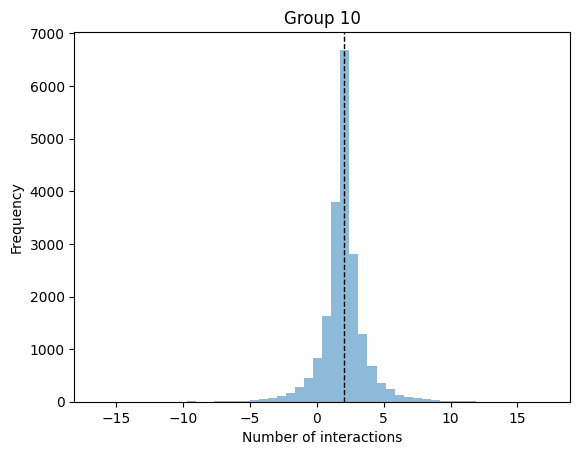

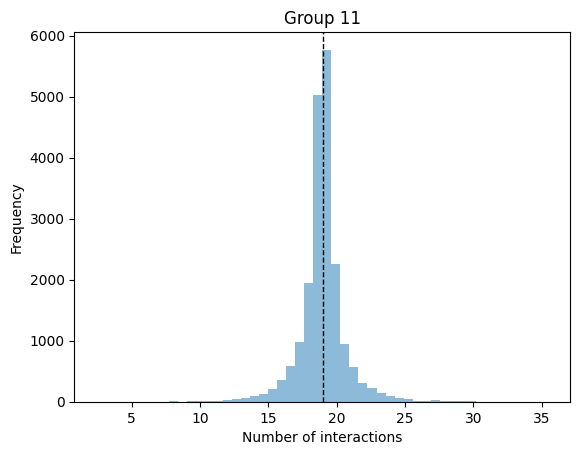

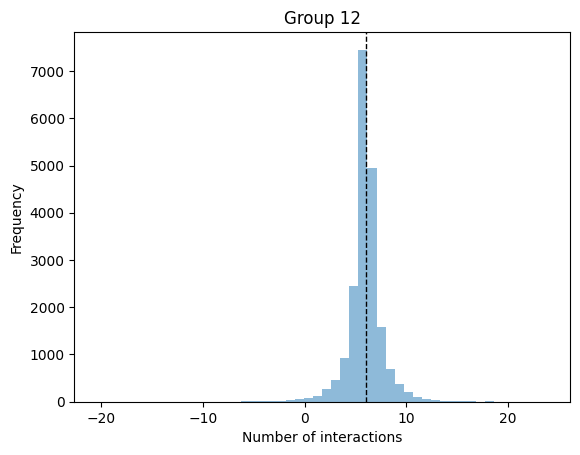

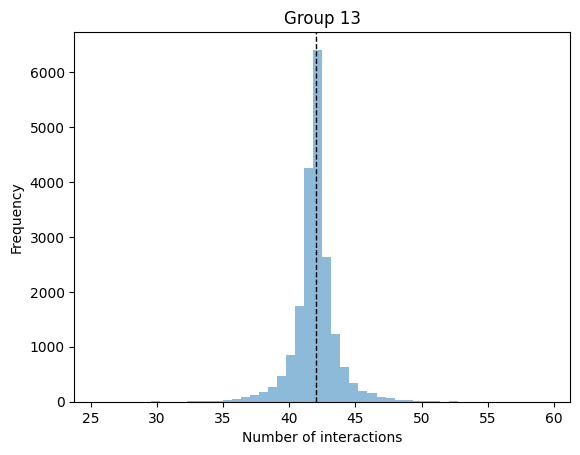

[24. 65. 39. 37. 37. 71. 19. 30. 43. 21.  2. 19.  6. 42.]


In [131]:
import pymc as pm
import arviz as az
import warnings
# regression model for num. of interactions of each group at each timestep
y = []
X = []
X1 = []
g_sum = 0

for group in groups:
    X.append(group_interactions.iloc[:,group.id-1]-group_interactions.iloc[:,group.id-1].shift(1))
    g = group_interactions.iloc[:,group.id-1]
    g_sum += g.sum()
    
    
    #plt.plot(group_interactions.iloc[:,group.id-1]-group_interactions.iloc[:,group.id-1].shift(1))
    
X = pd.DataFrame(X)
X.fillna(0, inplace=True)

y = X.iloc[:,-1]
y = pd.DataFrame(y)

y = y.to_numpy().flatten()


X = X.iloc[:,:-1]



model = pm.Model()

with model:
    try:
        # Data
        group_index = pm.Data('group_index', np.arange(num_groups), dims='group')
        X_data = pm.Data('X_data', X)
        y_data = pm.Data('y_data', y)

        # Priors
        rho = pm.Normal('phi', mu=0, sigma=g_sum/num_groups, shape=num_groups)
        sigma_ar = pm.Exponential('sigma_ar', lam=1.75)

        # AR Model
        ar = pm.AR('ar', rho=rho, sigma=sigma_ar, dims='group')

        # Likelihood
        sigma = pm.Exponential('sigma', lam=1.25)
        y_obs = pm.Normal('y_obs', mu=ar, sigma=sigma, observed=y_data, dims='group')

        # Sampling
        tune = 1000
        trace = pm.sample(5000, cores=4)
        posterior_predictive = pm.sample_posterior_predictive(trace)
    
    except pm.exceptions.SamplingError:
        warnings.warn('SamplingError: Skipping this group')


pred = posterior_predictive['posterior_predictive']['y_obs'].to_numpy()

shape = pred.shape
groups1 = shape[2]

# Initialize list of lists for each community
preds = [[] for _ in range(groups1)]

for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(groups1):
            preds[k].append(pred[i, j, k])

for k in range(groups1):

    plt.hist(preds[k], bins=50, alpha=0.5, label='Community 1')
    plt.axvline(y[k], color='k', linestyle='dashed', linewidth=1)
    title = 'Group ' + str(k)
    plt.title(title)
    plt.xlabel("Number of interactions")
    plt.ylabel("Frequency")
    plt.show()
    
print(y)


In [132]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
phi[0],-0.328,2668.829,-5045.189,5081.448,28.604,30.398,8775.0,4570.0,1.00
phi[1],18.974,2628.203,-4806.273,5101.652,24.802,23.276,11264.0,4726.0,1.00
phi[2],-47.758,2604.231,-5155.033,4772.110,31.609,27.156,6845.0,2729.0,1.00
phi[3],-54.991,2648.830,-4902.576,5008.945,27.517,25.717,9355.0,5507.0,1.00
phi[4],16.963,2656.064,-5128.417,4825.282,26.812,22.811,9811.0,8385.0,1.00
phi[5],-53.838,2616.669,-5083.673,4763.148,21.781,24.101,14398.0,7609.0,1.00
phi[6],-24.887,2660.650,-5152.316,4813.960,29.263,23.864,8252.0,4061.0,1.00
phi[7],-12.216,2614.719,-4839.528,4910.614,24.579,21.963,11367.0,6530.0,1.00
phi[8],-11.455,2644.980,-4827.770,5060.208,25.584,24.492,10711.0,7444.0,1.00
phi[9],0.296,2653.937,-4873.324,4933.360,24.109,23.695,12137.0,8754.0,1.00


In [190]:
'''import pymc as pm
import arviz as az
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

# multinomial logit model for group interactions
num_groups = len(groups)
y = []
X = []

for user in users:
    y.append(user.interaction_history[-1])
    # every interaction but the last one
    X.append(np.bincount(user.interaction_history[:-1], minlength=num_groups))


X = pd.DataFrame(X)
X.fillna(0, inplace=True)

y = pd.DataFrame(y)
y = y.iloc[:,0]

# drop first column if sum is 0
if X.iloc[:,0].sum() == 0:
    X = X.iloc[:,1:]
    if num_groups != X.shape[1]:
        num_groups -= (X.shape[1] - num_groups)

for row in range(len(X)):
    X.iloc[row] = X.iloc[row] / X.iloc[row].sum()

X.fillna(0, inplace=True)
X = (X - X.mean()) / X.std()
X.fillna(0, inplace=True)


model = pm.Model()


with model:
    try:

        indices = pm.Data('index', list(range(len(X))), dims='user')
        # Define your data within the model
        X_data = pm.Data('X_data', X)
        y_data = pm.Data('y_data', y)

        # Model parameters
        
        alpha = pm.Exponential('alpha', lam=np.max(group_relative_frequency), shape=num_groups)

        beta_mu = pm.Normal('beta_mu', mu=1, sigma=10, shape=num_groups)
        beta_sd = pm.TruncatedNormal('beta_sd', lower=0, mu=5, sigma=2.5, shape=num_groups)

        beta = pm.Normal('beta', mu=beta_mu, sigma=beta_sd, shape=(num_groups, num_groups))

        # Computing mu
        mu = alpha + pm.math.dot(X_data, beta) 

        # A numerically stable softmax
        mu_max = pm.math.max(mu, axis=1, keepdims=True)
        p = pm.Deterministic('p', pm.math.exp(mu - mu_max) / pm.math.sum(pm.math.exp(mu - mu_max), axis=1, keepdims=True))

        # Categorical distribution for observed data
        y_obs = pm.Categorical('y_obs', p=p, observed=y_data, dims='user')

        # Sampling
        trace = pm.sample(1000)
        posterior_predictive = pm.sample_posterior_predictive(trace)

    except pm.exceptions.SamplingError:
        model.debug(verbose=True)

y_pred = np.rint(posterior_predictive['posterior_predictive']['y_obs'].mean(axis=(0,1))) 

plt.scatter(y, y_pred)
plt.xlabel('Actual Group ID')
plt.ylabel('Predicted Group ID')
plt.show()

plt.scatter(y, y_pred - y)
plt.xlabel('Actual Group ID')
plt.ylabel('Residual')
plt.show()

print(az.summary(trace))

# kind of wack way to do it but shows r_hat distribution with the first nonzero value being 1 and incrementing by 0.01
# plt.plot(np.bincount(np.array(az.summary(trace)['r_hat'] * 100).astype(int)))'''

"import pymc as pm\nimport arviz as az\nimport warnings\n\nwarnings.simplefilter(action='ignore', category=FutureWarning)\nwarnings.simplefilter(action='ignore', category=UserWarning)\n\n# multinomial logit model for group interactions\nnum_groups = len(groups)\ny = []\nX = []\n\nfor user in users:\n    y.append(user.interaction_history[-1])\n    # every interaction but the last one\n    X.append(np.bincount(user.interaction_history[:-1], minlength=num_groups))\n\n\nX = pd.DataFrame(X)\nX.fillna(0, inplace=True)\n\ny = pd.DataFrame(y)\ny = y.iloc[:,0]\n\n# drop first column if sum is 0\nif X.iloc[:,0].sum() == 0:\n    X = X.iloc[:,1:]\n    if num_groups != X.shape[1]:\n        num_groups -= (X.shape[1] - num_groups)\n\nfor row in range(len(X)):\n    X.iloc[row] = X.iloc[row] / X.iloc[row].sum()\n\nX.fillna(0, inplace=True)\nX = (X - X.mean()) / X.std()\nX.fillna(0, inplace=True)\n\n\nmodel = pm.Model()\n\n\nwith model:\n    try:\n\n        indices = pm.Data('index', list(range(len(X)))